In [4]:
import os
import os.path
import numpy as np
import datetime

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

  pandas: 2.1.2


In [6]:
# load dataset
asset_prices = pd.read_csv('spx_holdings_and_spx_closeprice_m2-ex3.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

C:\Users\mynjn\AppData\Local\Temp\ipykernel_13220\3313095476.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  asset_prices = pd.read_csv('spx_holdings_and_spx_closeprice_m2-ex3.csv',


Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


In [7]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


In [18]:
asset_returns = pd.DataFrame(data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])), 
                             columns=asset_prices.columns.values,
                             index=asset_prices.index)
normed_returns = asset_returns
# normed_returns is pandas.DataFrame that should contain normalized returns
asset_returns = asset_prices.pct_change().dropna()
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()

normed_returns.iloc[-5:, -10:].head()

,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2013-12-16,0.852722,0.965219,-1.168885,0.884751,0.095865,0.656639,0.180014,-0.238498,0.465047,0.467931
2013-12-17,0.275173,0.517307,-0.086106,-0.306213,0.589689,-0.118610,-0.549523,0.025268,-0.260013,-0.247921
2013-12-18,0.864485,0.509435,0.600714,1.210605,-0.190024,0.925461,0.756998,0.058428,0.952458,1.252703
2013-12-19,0.210069,0.399574,-0.100159,-0.757419,-0.208023,0.304913,-0.772205,1.544228,-0.167775,-0.056358
2013-12-20,0.827306,0.748420,0.372443,1.048113,0.264046,0.436874,0.320641,-0.740854,0.373717,0.353859


In [19]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 419)
Test dataset: (437, 419)


In [20]:
import sklearn.decomposition
import seaborn as sns

stock_tickers = normed_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix

if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns.values[:-1]
    assert 'SPX' not in stock_tickers, "By accident included SPX index"
    
    #normed covariance matrix
    cov_matrix = df_train.loc[:, df_train.columns != 'SPX'].cov()    

    # computing PCA on S&P 500 stocks
    from sklearn.decomposition import PCA
    pca = PCA().fit(cov_matrix)

    # not normed covariance matrix
    cov_matrix_raw = df_raw_train.loc[:, df_raw_train.columns != 'SPX'].cov()
    
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
    
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

4 components explain 80.00% of variance


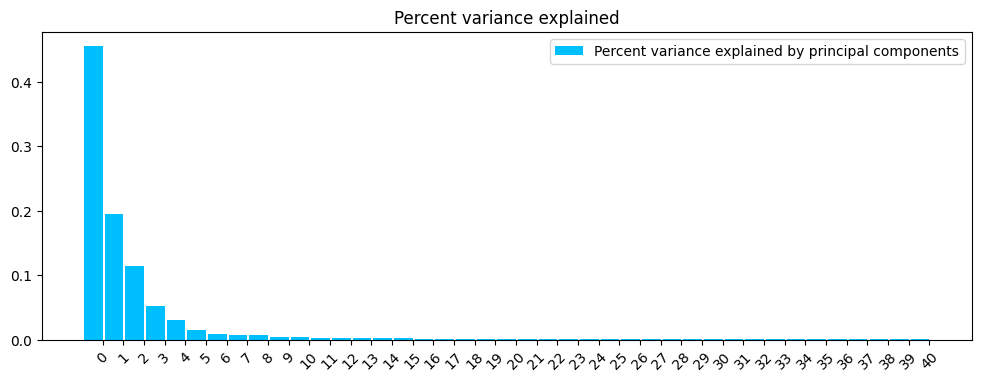

In [21]:
if pca is not None:
    bar_width = 0.9
    n_asset = int((1 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

In [22]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)

C:\Users\mynjn\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\mynjn\AppData\Local\Temp\ipykernel_13220\2054083128.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))


Sum of weights of first eigen-portfolio: 100.00


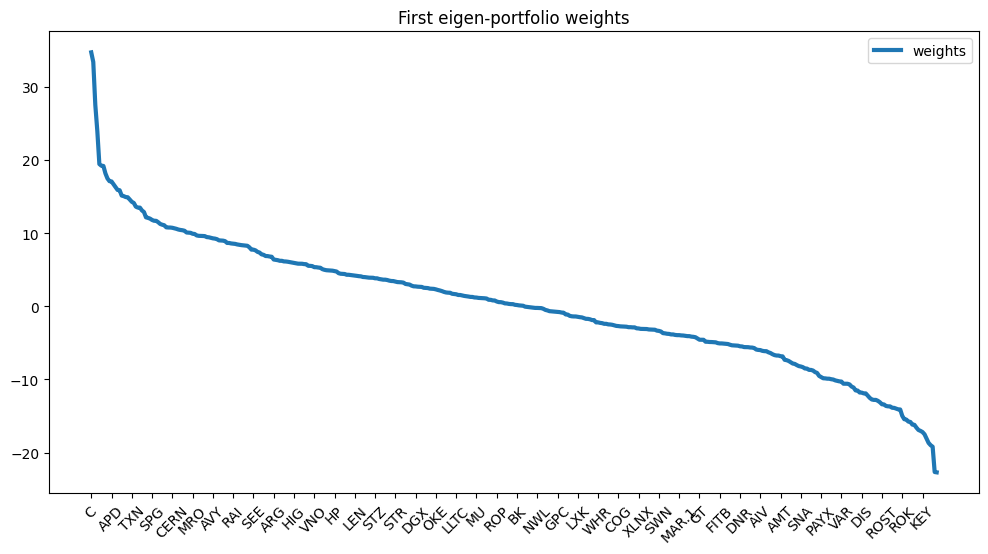

In [23]:
# the first two eigen-portfolio weights# the fi 
# first component
# get the Principal components
pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
if pca is not None:
    pcs = pca.components_

    # normalized to 1 
    pc_w = pcs[:, 0] / sum(pcs[:, 0])
    
    eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights', 
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

We sort the first two eigen portfolio weights and plot the results.

C:\Users\mynjn\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\mynjn\AppData\Local\Temp\ipykernel_13220\3557475576.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))


Sum of weights of second eigen-portfolio: 100.00


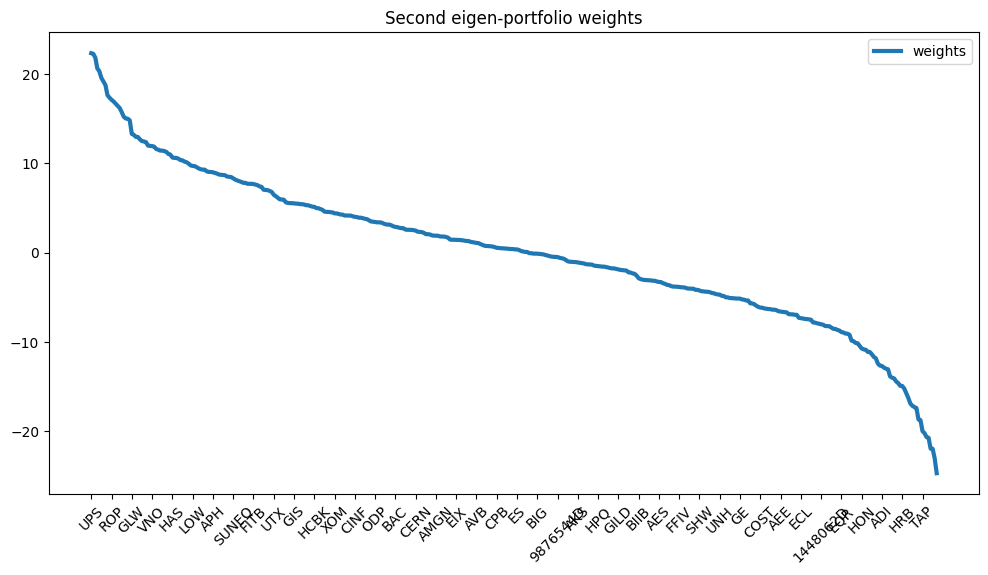

In [24]:
pc_w = np.zeros(len(stock_tickers))
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_
    
    # normalized to 1 
    pc_w = pcs[:, 1] / sum(pcs[:, 1])
    
    eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf2.plot(title='Second eigen-portfolio weights',
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

In [25]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns),(1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
   
    
    return annualized_return, annualized_vol, annualized_sharpe

First eigen-portfolio:
Return = 42.98%
Volatility = 33.66%
Sharpe = 1.28


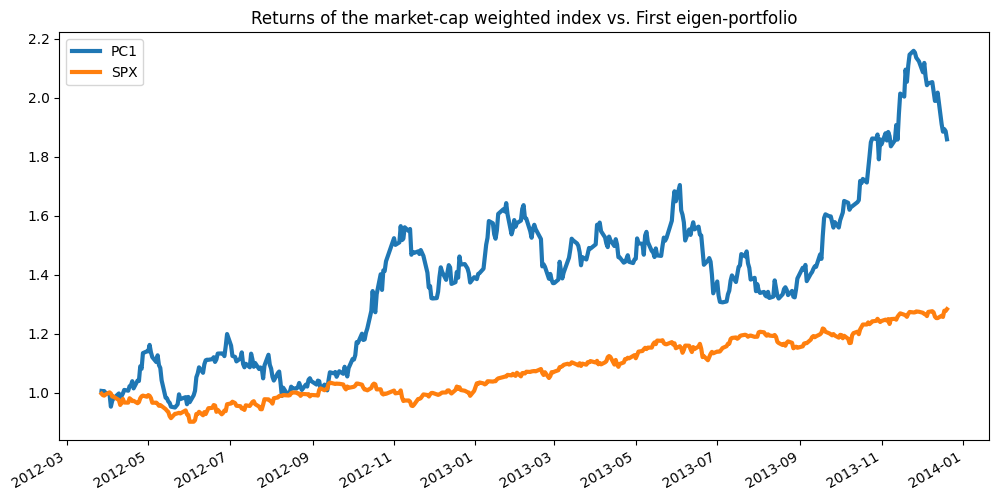

In [26]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

In [27]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))

Second eigen-portfolio:
Return = 17.57%
Volatility = 35.37%
Sharpe = 0.50


C:\Users\mynjn\AppData\Local\Temp\ipykernel_13220\429601496.py:18: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1 + ts_returns),(1 / n_years)) - 1
C:\Users\mynjn\AppData\Local\Temp\ipykernel_13220\429601496.py:18: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1 + ts_returns),(1 / n_years)) - 1


Eigen portfolio #6 with the highest Sharpe. Return 27078580483.29%, vol = 3032.95%, Sharpe = 8928132.14


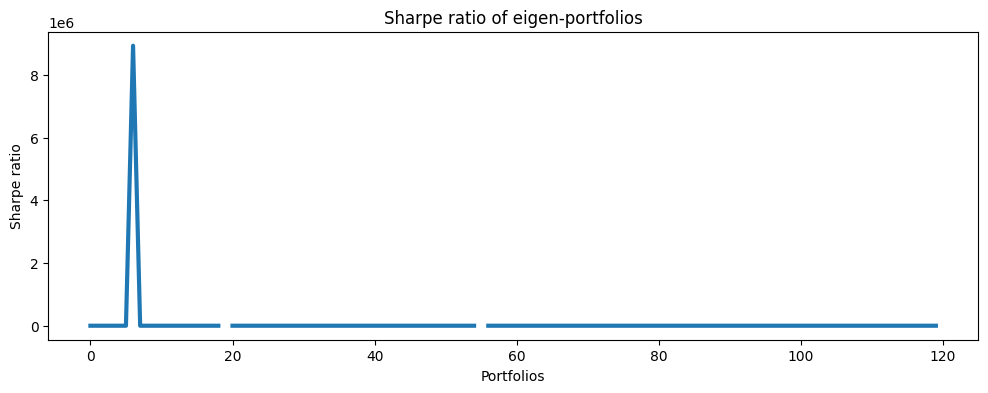

In [28]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio
    
if pca is not None:
    for ix in range(n_portfolios):
    
        pc_w = pcs[:, ix] / sum(pcs[:, ix])
        eigen_prtfix = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfix.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prtix_returns = np.dot(df_raw_test.loc[:, eigen_prtfix.index], eigen_prtfix / 100)
        eigen_prtix_returns = pd.Series(eigen_prtix_returns.squeeze(), index=df_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prtix_returns)
        annualized_ret[ix] = er
        annualized_vol[ix] = vol
        sharpe_metric[ix] = sharpe
    
    
    # find portfolio with the highest Sharpe ratio
    idx_highest_sharpe = np.nanargmax(sharpe_metric)
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [29]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
6,2.707858e+08,30.329502,8.928132e+06
42,6.507218e-01,0.236410,2.752508e+00
104,5.408715e-01,0.221470,2.442189e+00
24,8.357680e-01,0.351945,2.374712e+00
97,1.719756e+00,0.731894,2.349733e+00
9,7.900076e-01,0.341566,2.312902e+00
2,4.641763e-01,0.209092,2.219961e+00
94,4.783928e-01,0.217899,2.195483e+00
93,5.748383e-01,0.262132,2.192937e+00
118,1.243794e+00,0.694505,1.790908e+00
